In [25]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import cv2
import os
import pandas as pd

In [26]:
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor

sam_checkpoint = "sam_vit_h_4b8939.pth"
model_type = "vit_h"

device = "cuda"

sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device=device);


In [77]:
folder = 'potato_data/'
folder_out = 'potato_output/'

imnames = [x for x in os.listdir(folder) if '.JPG' in x]  # get list of image files change .JPG is using files of different type

In [28]:
def checkcolour(masks, hsv):
    colours = np.zeros((0,3))

    for i in range(len(masks)):
        color = hsv[masks[i]['segmentation']].mean(axis=(0))
        colours = np.append(colours,color[None,:], axis=0)
        
    idx_green = (colours[:,0]<75) & (colours[:,0]>35) & (colours[:,1]>35)
    if idx_green.sum()==0:
        # grow lights on adjust
        idx_green = (colours[:,0]<100) & (colours[:,0]>35) & (colours[:,1]>35)
    
    return(idx_green)

In [29]:
def checkfullplant(masks):
    mask_all = np.zeros(masks[0]['segmentation'].shape[:2])

    for mask in masks:
        mask_all +=mask['segmentation']*1
        
    iou_withall = []
    for mask in masks:
        iou_withall.append(iou(mask['segmentation'], mask_all>0))
        
    idx_notall = np.array(iou_withall)<0.9
    return idx_notall

In [30]:
def getbiggestcontour(contours):
    nopoints = [len(cnt) for cnt in contours]
    return(np.argmax(nopoints))

def checkshape(masks):
    cratio = []

    for i in range(len(masks)):
        test_mask = masks[i]['segmentation']
        
        if not test_mask.max():
            cratio.append(0)
        else:

            contours,hierarchy = cv2.findContours((test_mask*255).astype('uint8'), 1, 2)

            # multiple objects possibly detected. Find contour with most points on it and just use that as object
            cnt = contours[getbiggestcontour(contours)]
            M = cv2.moments(cnt)

            area = cv2.contourArea(cnt)
            perimeter = cv2.arcLength(cnt,True)

            (x,y),radius = cv2.minEnclosingCircle(cnt)

            carea = np.pi*radius**2

            cratio.append(area/carea)
    idx_shape = np.array(cratio)>0.1
    return(idx_shape)

In [31]:
def iou(gtmask, test_mask):
    intersection = np.logical_and(gtmask, test_mask)
    union = np.logical_or(gtmask, test_mask)
    iou_score = np.sum(intersection) / np.sum(union)
    return (iou_score)

In [32]:
def issubset(mask1, mask2):
    # is mask2 subpart of mask1
    intersection = np.logical_and(mask1, mask2)
    return(np.sum(intersection)/mask2.sum()>0.9)

def istoobig(masks):
    idx_toobig = []
    
    mask_all = np.zeros(masks[0]['segmentation'].shape[:2])

    for mask in masks:
        mask_all +=mask['segmentation']*1 

    for idx in range(len(masks)):
        if idx in idx_toobig:
            continue
        for idx2 in range(len(masks)):
            if idx==idx2:
                continue
            if idx2 in idx_toobig:
                continue
            if issubset(masks[idx2]['segmentation'], masks[idx]['segmentation']):
                # check if actually got both big and small copy delete if do
                if mask_all[masks[idx2]['segmentation']].mean() > 1.5:
                
                    idx_toobig.append(idx2)
    
    idx_toobig.sort(reverse=True)        
    return(idx_toobig)

def remove_toobig(masks, idx_toobig):
    masks_ntb = masks.copy()

    idx_del = []
    for idxbig in idx_toobig[1:]:
        maskbig = masks_ntb[idxbig]['segmentation'].copy()
        submasks = np.zeros(maskbig.shape)

        for idx in range(len(masks_ntb)):
            if idx==idxbig:
                continue
            if issubset(masks_ntb[idxbig]['segmentation'], masks_ntb[idx]['segmentation']):
                submasks +=masks_ntb[idx]['segmentation']

        if np.logical_and(maskbig, submasks>0).sum()/maskbig.sum()>0.9:
            # can safely remove maskbig
            idx_del.append(idxbig)
            del(masks_ntb[idxbig])
            
    return(masks_ntb)

In [33]:
print(imnames)

['IMG_8013.JPG', 'IMG_8020.JPG', 'IMG_8008.JPG', 'IMG_8009.JPG', 'IMG_8003.JPG', 'IMG_8014.JPG', 'IMG_8007.JPG', 'IMG_8011.JPG', 'IMG_8019.JPG', 'IMG_8005.JPG', 'IMG_8010.JPG', 'IMG_8015.JPG', 'IMG_8021.JPG', 'IMG_8001.JPG', 'IMG_8002.JPG', 'IMG_8012.JPG', 'IMG_8016.JPG', 'IMG_8006.JPG', 'IMG_8017.JPG']


In [35]:
for imname in imnames:
    print(imname)
    image = cv2.imread(folder + imname)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image,None,fx=0.5,fy=0.5)   # downsize image to fit on gpu easier may not be needed
    hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
           
    # use crop_n_layer=1 to improve results on smallest leaves 
    mask_generator = SamAutomaticMaskGenerator(
        model=sam,
        points_per_side=32,
        pred_iou_thresh=0.88,
        stability_score_thresh=0.95,
        crop_n_layers=1,
        crop_n_points_downscale_factor=2,
        min_mask_region_area=200,  
    )

    # get masks
    masks = mask_generator.generate(image)
    
    # remove things that aren't green enough to be leaves
    idx_green = checkcolour(masks,hsv)

    masks_g = []
    for idx, use in enumerate(idx_green):
        if use:
            masks_g.append(masks[idx])

    if len(masks_g) > 2:

        # check to see if full plant detected and remove
        idx_notall = checkfullplant(masks_g)

        masks_na = []

        for idx, use in enumerate(idx_notall):
            if use:
                masks_na.append(masks_g[idx])

    else:
        masks_na = masks_g

    idx_shape = checkshape(masks_na)

    masks_s = []
    for idx, use in enumerate(idx_shape):
        if use:
            masks_s.append(masks_na[idx])

    idx_toobig = istoobig(masks_s)
    masks_ntb = remove_toobig(masks_s, idx_toobig)
    
    # save results at each step as npz file 
    np.savez(folder_out + imname.replace('.JPG','leafonly_allmasks.npz'),
              masks, masks_g, masks_na, masks_s, masks_ntb)


IMG_8013.JPG
IMG_8020.JPG
IMG_8008.JPG
IMG_8009.JPG
IMG_8003.JPG
IMG_8014.JPG
IMG_8007.JPG
IMG_8011.JPG
IMG_8019.JPG
IMG_8005.JPG
IMG_8010.JPG
IMG_8015.JPG
IMG_8021.JPG
IMG_8001.JPG
IMG_8002.JPG
IMG_8012.JPG
IMG_8016.JPG
IMG_8006.JPG
IMG_8017.JPG


(3456, 4608, 3)


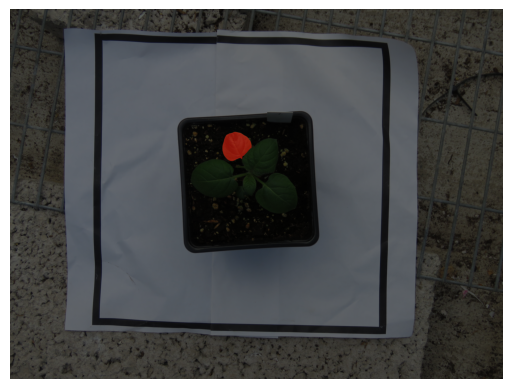

In [109]:
import matplotlib.image as mpimg

# Load the .npz file with allow_pickle=True
mask_data = np.load('potato_output/IMG_8001leafonly_allmasks.npz', allow_pickle=True)

# Specify the path to your image
image_path = 'potato_data/IMG_8001.JPG'

# Load the image
image = mpimg.imread(image_path)
plt.imshow(image)
print(image.shape)

# for item in mask_data.files:

combined_mask = np.zeros((image.shape[0], image.shape[1]), dtype=np.uint8)

for mask in mask_data['arr_4']:
        
    segmentation_info = mask
    segmentation_mask = segmentation_info['segmentation']
    resized_mask = cv2.resize(segmentation_mask.astype(float), (image.shape[1], image.shape[0]), interpolation=cv2.INTER_NEAREST)
    resized_mask = resized_mask.astype(bool)
    combined_mask = np.logical_or(combined_mask, resized_mask)

    
# Create a mask overlay with a specific color
mask_overlay = np.zeros_like(image)
mask_overlay[resized_mask] = [255, 0, 0]
    

# Overlay the mask with transparency
plt.imshow(mask_overlay, alpha=0.5)  # Adjust alpha for desired transparency

plt.axis('off') 
plt.show()


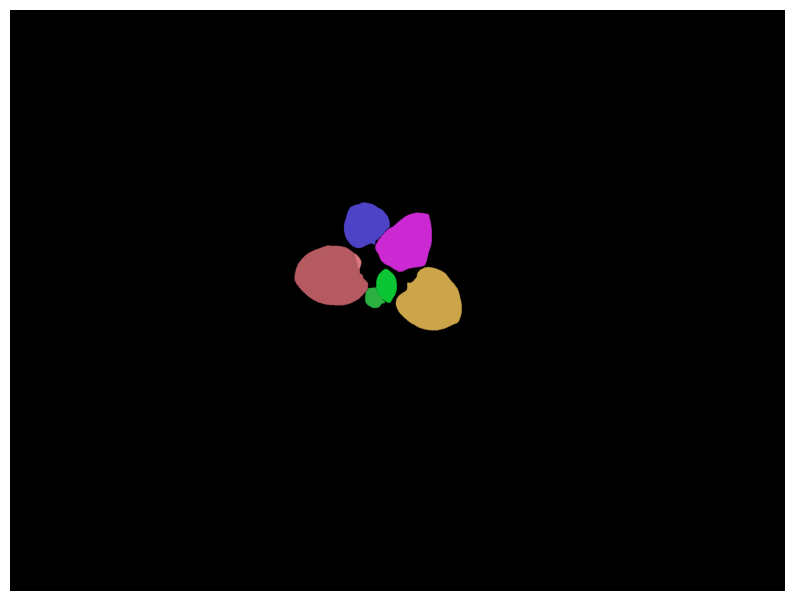

In [112]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
from skimage import color
import random

def generate_unique_color(existing_colors):
    """
    Generate a unique random color that's not in existing_colors.
    """
    while True:
        new_color = [random.randint(0, 255) for _ in range(3)]
        if not any((np.array(new_color) == x).all() for x in existing_colors):
            return new_color

# Load the .npz file with allow_pickle=True
mask_data = np.load('potato_output/IMG_8001leafonly_allmasks.npz', allow_pickle=True)

# Specify the path to your image
image_path = 'potato_data/IMG_8020.JPG'

# Load the image
image = mpimg.imread(image_path)

# Prepare a canvas with the same dimensions as the image but all zeros (black)
overlay = np.zeros_like(image)

# Store used colors to ensure uniqueness
used_colors = []

# Loop through each mask
for i, mask in enumerate(mask_data['arr_4'][:-1]):
    segmentation_info = mask
    segmentation_mask = segmentation_info['segmentation']
    
    # Resize the mask to match the image's dimensions
    resized_mask = cv2.resize(segmentation_mask.astype(float), (image.shape[1], image.shape[0]), interpolation=cv2.INTER_NEAREST)
    resized_mask = resized_mask > 0.5  # Make sure the mask is binary

    # Generate a unique color for this mask
    unique_color = generate_unique_color(used_colors)
    used_colors.append(unique_color)
    
    # Apply the color to the overlay where the mask is true
    overlay[resized_mask] = unique_color

# Blend the original image and the overlay
# Convert overlay to float and scale from 0 to 1 for blending
overlay_float = overlay.astype(np.float64) / 255
image_float = image.astype(np.float64) / 255
blended_image = (overlay_float + image_float) / 2

# Display the blended image
plt.figure(figsize=(10, 10))
plt.imshow(overlay)
plt.axis('off')
plt.show()


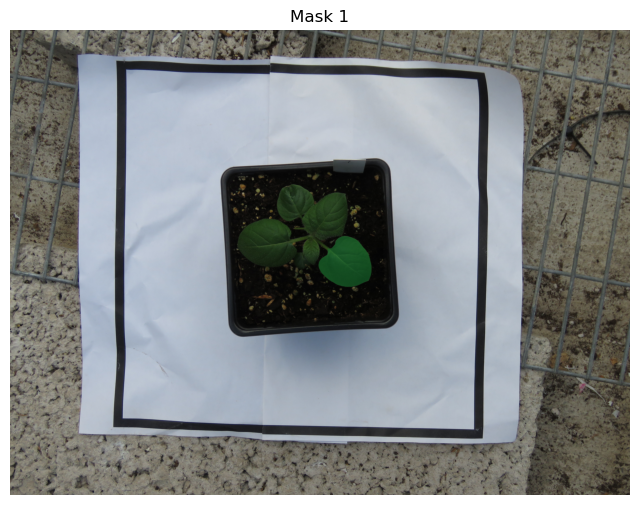

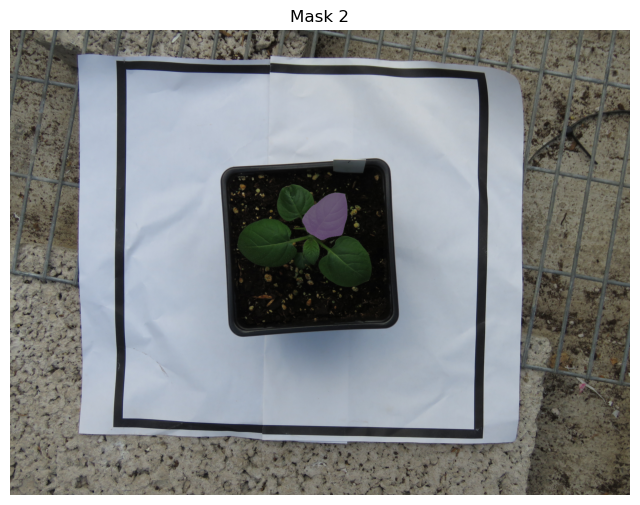

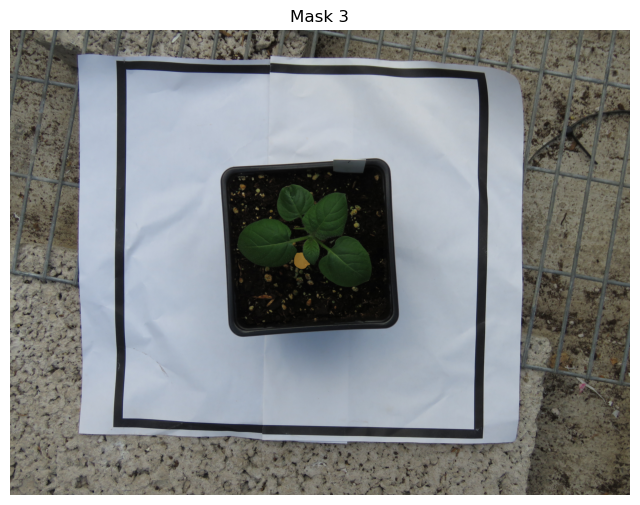

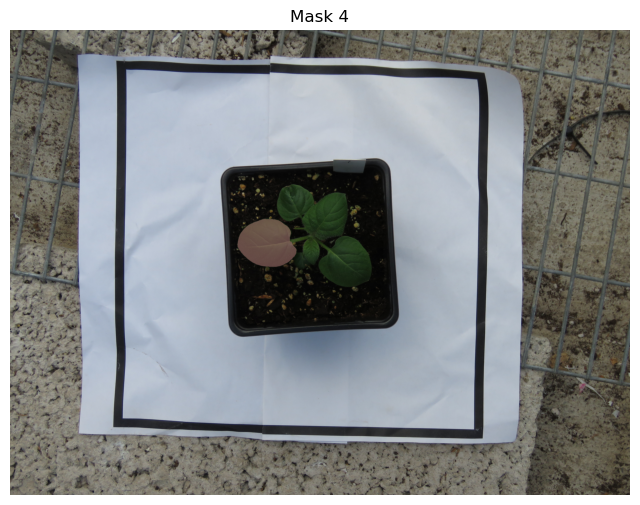

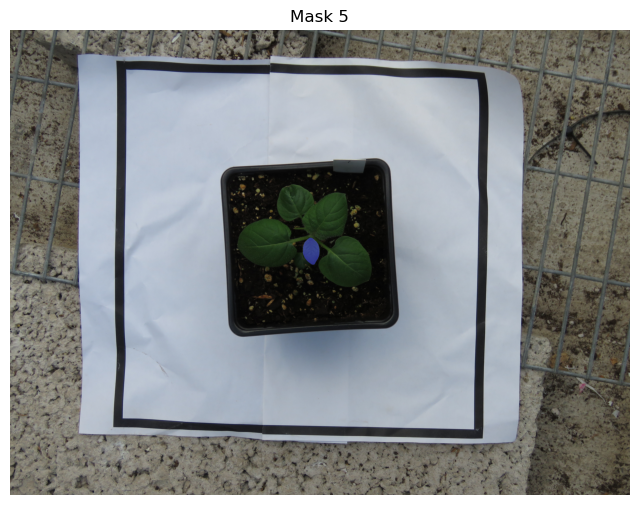

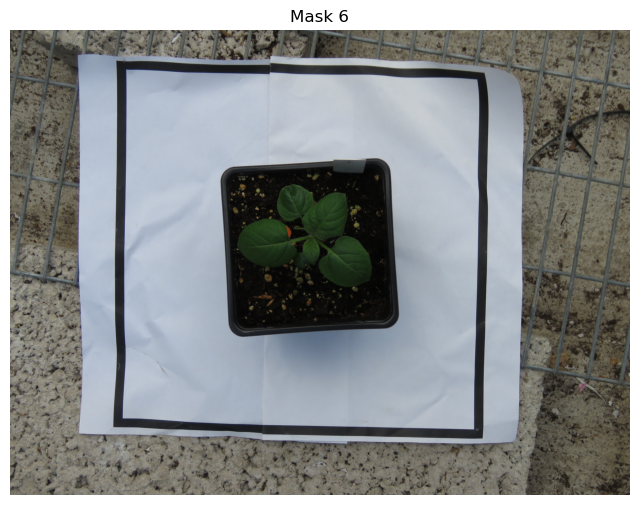

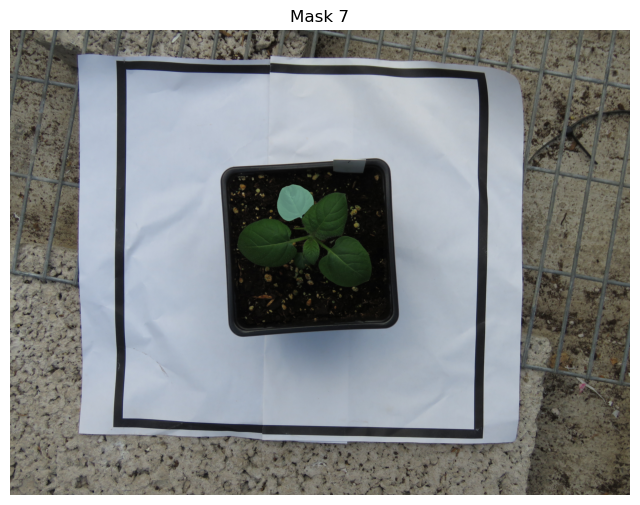

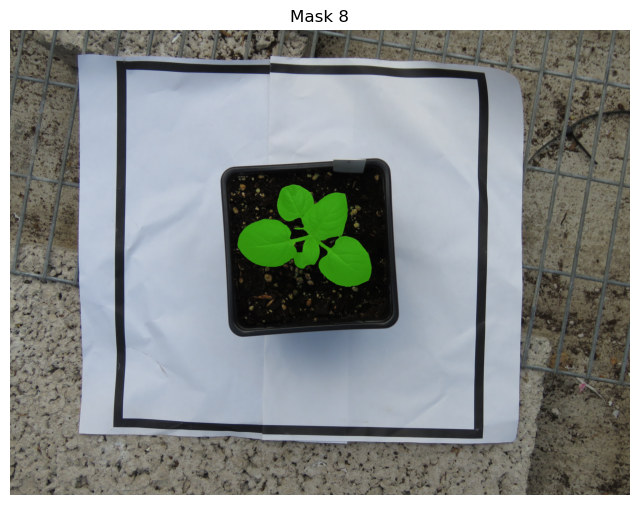

In [107]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2

# Load the .npz file with allow_pickle=True
mask_data = np.load('potato_output/IMG_8001leafonly_allmasks.npz', allow_pickle=True)

# Specify the path to your image
image_path = 'potato_data/IMG_8001.JPG'

# Load the image
image = mpimg.imread(image_path)

def apply_mask_to_image(image, mask):
    """
    Apply a single mask to the image, creating a colored overlay
    """
    # Create an overlay that is a copy of the original image
    overlay = image.copy()
    
    # Generate a random color for the mask
    color = np.array([random.randint(0, 255) for _ in range(3)], dtype=np.uint8)
    
    # Resize mask to match image dimensions
    resized_mask = cv2.resize(mask.astype(float), (image.shape[1], image.shape[0]), interpolation=cv2.INTER_NEAREST)
    resized_mask = resized_mask > 0.5  # Ensure binary mask
    
    # Apply the color to the overlay where the mask is true
    overlay[resized_mask] = overlay[resized_mask] * 0.5 + color * 0.5
    
    return overlay

# Iterate through each mask and display it with the original image
for i, mask in enumerate(mask_data['arr_4']):
    segmentation_info = mask
    segmentation_mask = segmentation_info['segmentation']
    
    # Apply the current mask to the image
    masked_image = apply_mask_to_image(image, segmentation_mask)
    
    # Display the image with the current mask applied
    plt.figure(figsize=(8, 8))
    plt.imshow(masked_image)
    plt.title(f'Mask {i+1}')
    plt.axis('off')
    plt.show()


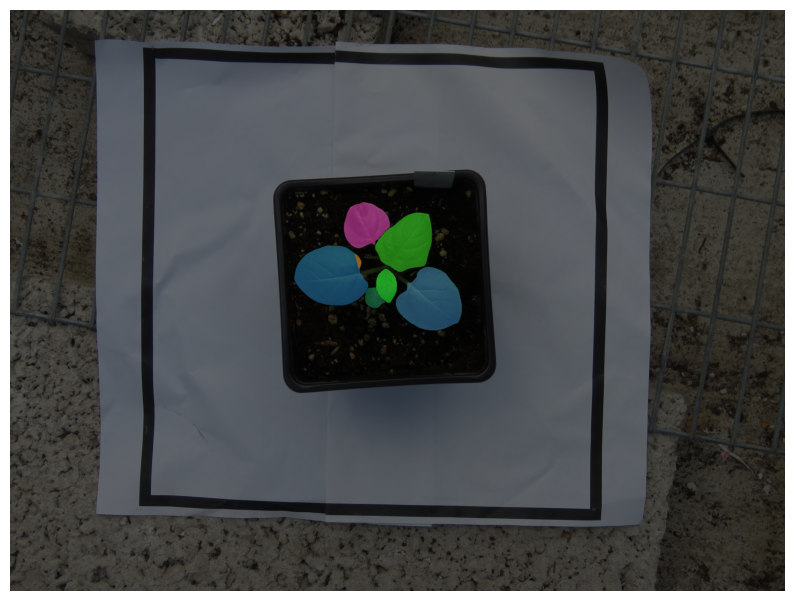

In [114]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
from skimage import color
import random

def generate_unique_color(existing_colors):
    """
    Generate a unique random color that's not in existing_colors.
    """
    while True:
        new_color = [random.randint(0, 255) for _ in range(3)]
        if not any((np.array(new_color) == x).all() for x in existing_colors):
            return new_color

# Load the .npz file with allow_pickle=True
mask_data = np.load('potato_output/IMG_8001leafonly_allmasks.npz', allow_pickle=True)

# Specify the path to your image
image_path = 'potato_data/IMG_8001.JPG'

# Load the image
image = mpimg.imread(image_path)

# Prepare a canvas with the same dimensions as the image but all zeros (black)
overlay = np.zeros_like(image)

# Store used colors to ensure uniqueness
used_colors = []

# Loop through each mask
for i, mask in enumerate(mask_data['arr_4'][:-1]):
    segmentation_info = mask
    segmentation_mask = segmentation_info['segmentation']
    
    # Resize the mask to match the image's dimensions
    resized_mask = cv2.resize(segmentation_mask.astype(float), (image.shape[1], image.shape[0]), interpolation=cv2.INTER_NEAREST)
    resized_mask = resized_mask > 0.5  # Make sure the mask is binary

    # Generate a unique color for this mask
    unique_color = generate_unique_color(used_colors)
    used_colors.append(unique_color)
    
    # Apply the color to the overlay where the mask is true
    overlay[resized_mask] = unique_color

# Blend the original image and the overlay
# Convert overlay to float and scale from 0 to 1 for blending
overlay_float = overlay.astype(np.float64) / 255
image_float = image.astype(np.float64) / 255
blended_image = (overlay_float + image_float) / 2

# Display the blended image
plt.figure(figsize=(10, 10))
plt.imshow(blended_image)
plt.axis('off')
plt.show()